In [11]:
# Cell One: imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 200)
sns.set_style('whitegrid')

print("Imports ok")

Imports ok


In [12]:
# Cell two: load and view CSV  
df = pd.read_csv('survey.csv')
print("Shape:", df.shape)
display(df.head(6))
display(df.info())

Shape: (1259, 27)


,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,No,Yes,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,No,No,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,No,Yes,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,No,Yes,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,Yes,Yes,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN
5,2014-08-27 11:31:22,33,Male,United States,TN,NaN,Yes,No,Sometimes,6-25,No,Yes,Yes,Not sure,No,Don't know,Don't know,Don't know,No,No,Yes,Yes,No,Maybe,Don't know,No,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-null   object
 11  tech_company               1259 non-null   object
 12  benefits                   1259 non-null   object
 13  care_options               1259 non-null   object
 14  wellness

None

Columns: ['Timestamp', 'Age', 'Gender', 'Country', 'state', 'self_employed', 'family_history', 'treatment', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence', 'comments']

Target value counts (treatment):
treatment
Yes    637
No     622
Name: count, dtype: int64


comments          86.97
state             40.91
work_interfere    20.97
self_employed      1.43
dtype: float64

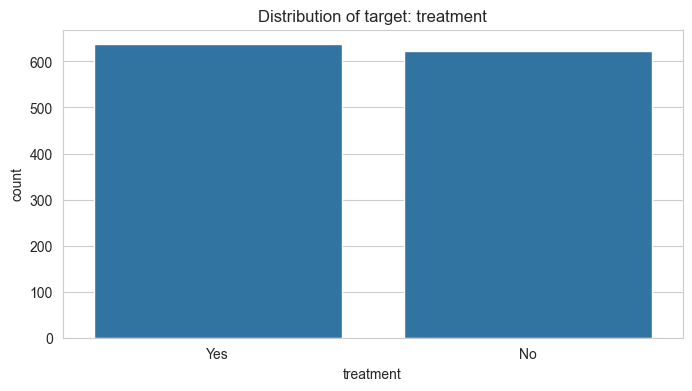

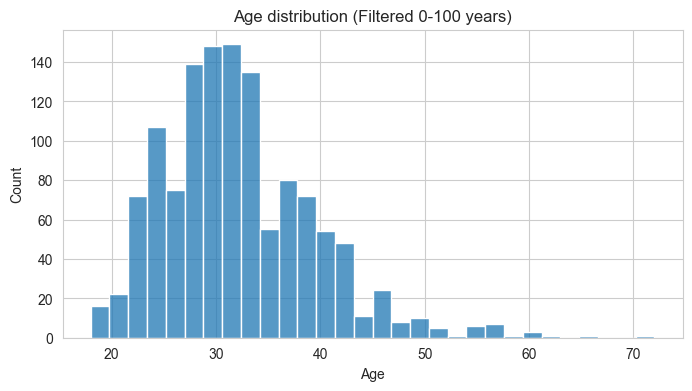

In [13]:
# Cell three:Exploratory Data Analysis
print("Columns:", list(df.columns))
print("\nTarget value counts (treatment):")
print(df['treatment'].value_counts(dropna=False))

# Missing values %
missing_pct = df.isna().mean().sort_values(ascending=False) * 100
display(missing_pct[missing_pct>0].round(2))

# Visualization
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='treatment', order=df['treatment'].value_counts().index)
plt.title('Distribution of target: treatment')
plt.show()

# Age
plt.figure(figsize=(8,4))

# 1. Outliers removal
df2 = df[(df['Age'] >= 14) & (df['Age'] <= 100)].copy()

# 2. Usamos esse novo DataFrame para o gráfico
sns.histplot(df2['Age'].dropna(), bins=30)
plt.title('Age distribution (Filtered 0-100 years)')
plt.show()

In [14]:
# Cell 4 (THE REAL, ALL-IN-ONE PREP CELL - v3 - THE FINAL ONE)
import warnings
import pandas as pd
from sklearn.preprocessing import FunctionTransformer # <-- VAMOS PRECISAR DISTO

# --- 1. Define Cleaning Function ---
def clean_gender(x):
    if pd.isna(x): return 'Other'
    s = str(x).strip().lower()
    if s in ['male', 'm', 'man', 'male-ish', 'maile', 'mal', 'cis male', 'male (cis)']: return 'Male'
    if s in ['female', 'f', 'woman', 'female (cis)', 'cis female']: return 'Female'
    return 'Other'

# --- 2. Copy df2 and APPLY ALL CLEANING ---
df3 = df2.copy()

# Clean Gender
df3['Gender_clean'] = df3['Gender'].apply(clean_gender)

# Clean binary columns
bin_cols = ['self_employed','family_history','treatment','remote_work','tech_company',
            'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity']

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    for c in bin_cols:
        if c in df3.columns:
            series = df3[c].replace({'Yes':1, 'No':0})
            df3.loc[:, c] = pd.to_numeric(series, errors='coerce')
print("df3 cleaned (Gender and binary columns).")

# --- 3. Define Features ---
candidate_features = [
    'Age', 'Gender_clean', 'self_employed', 'family_history',
    'work_interfere', 'no_employees', 'remote_work', 'tech_company',
    'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity'
]
candidate_features = [c for c in candidate_features if c in df3.columns]
print("Candidate features selected.")

# --- 4. Define Preprocessor (COM A CORREÇÃO DO 'TypeError') ---
num_features = [c for c in candidate_features if df3[c].dtype in ['int64','float64'] and c!='treatment']
cat_features = [c for c in candidate_features if c not in num_features]
print(f"Num features: {num_features}")
print(f"Cat features: {cat_features}")

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# --- AQUI ESTÁ A CORREÇÃO ---
# Vamos forçar tudo o que entra aqui a ser uma string
# O Imputer corre, depois convertemos tudo para string, depois o OneHotEncoder corre.
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('to_string', FunctionTransformer(lambda x: x.astype(str))), # <-- O ERRO MORRE AQUI
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
# -----------------------------

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
], remainder='drop', sparse_threshold=0)
print("Preprocessor created.")

# --- 5. Define X and y (WITH ALL FIXES) ---
target_col = 'treatment'
print(f"Shape before dropping target NaNs: {df3.shape}")
df3 = df3.dropna(subset=[target_col])
print(f"Shape after dropping target NaNs: {df3.shape}")

X = df3[candidate_features] 
y = df3[target_col] # Isto já é 1.0 / 0.0 da limpeza que fizemos em cima
print("Target column 'y' is now numeric.")

# --- 6. Split the data ---
STATE = 42 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=STATE, 
    stratify=y
)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

# --- 7. Build the RF Pipeline ---
pipe_rf = Pipeline([
    ('pre', preprocessor), 
    ('model', RandomForestClassifier(
        random_state=STATE,
        class_weight='balanced'
    ))
])
print("Random Forest pipeline created.")
print("--- ALL PREP IS DONE. YOU ARE CLEAR TO RUN CELL 8 (agora é a Cell 5). ---")

df3 cleaned (Gender and binary columns).
Candidate features selected.
Num features: ['Age']
Cat features: ['Gender_clean', 'self_employed', 'family_history', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity']
Preprocessor created.
Shape before dropping target NaNs: (1251, 28)
Shape after dropping target NaNs: (1251, 28)
Target column 'y' is now numeric.
X_train shape: (1000, 13), y_train shape: (1000,)
Random Forest pipeline created.
--- ALL PREP IS DONE. YOU ARE CLEAR TO RUN CELL 8 (agora é a Cell 5). ---


In [15]:
# Cell 5 (THE NEW, FINAL, ATOMIC BOMB CELL - Replaces your old GridSearch cell)
import pandas as pd
import numpy as np

# --- ESTA PARTE JÁ CORREU, MAS NÃO FAZ MAL CORRER DE NOVO ---
print("--- FORCING DATA CLEANUP ---")
print(f"Data type in y_train BEFORE fix: {y_train.dtype}")
print("Value counts in y_train BEFORE fix:")
print(y_train.value_counts(dropna=False)) 

y_temp_numeric = pd.to_numeric(y_train.replace({'Yes': 1, 'No': 0}), errors='coerce')
mask = y_temp_numeric.notna()
X_train_clean = X_train[mask]
y_train_clean = y_temp_numeric[mask]

print("\n--- DATA IS NOW CLEAN ---")
print("Value counts in y_train AFTER fix:")
print(y_train_clean.value_counts(dropna=False)) 
print(f"Shape of X_train (clean): {X_train_clean.shape}")
print(f"Shape of y_train (clean): {y_train_clean.shape}")

# --- 2. NOW WE RUN THE GRIDSEARCH ON THE CLEAN DATA ---
param_grid_rf = {
    'model__n_estimators': [100, 150],       # Number of trees
    'model__max_depth': [10, 15, None],      # How deep trees can go (None = full)
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=STATE)
grid_rf = GridSearchCV(
    pipe_rf, 
    param_grid_rf, 
    cv=cv, 
    scoring='f1', 
    n_jobs=4     # Using 4 cores
)

print("\nStarting GridSearch on CLEAN data... this may take a minute.")
import time
start_time = time.time()

grid_rf.fit(X_train_clean, y_train_clean) 

end_time = time.time()
print(f"GridSearch took {end_time - start_time:.2f} seconds.")
print("---")

# --- A CORREÇÃO ESTÁ AQUI ---
print(f"Best F1 score (in CV): {grid_rf.best_score_:.4f}")  # <-- Adiciona o underscore
print("Best parameters found:")
print(grid_rf.best_params_) # <-- Adiciona o underscore

--- FORCING DATA CLEANUP ---
Data type in y_train BEFORE fix: object
Value counts in y_train BEFORE fix:
treatment
1    505
0    495
Name: count, dtype: int64

--- DATA IS NOW CLEAN ---
Value counts in y_train AFTER fix:
treatment
1    505
0    495
Name: count, dtype: int64
Shape of X_train (clean): (1000, 13)
Shape of y_train (clean): (1000,)

Starting GridSearch on CLEAN data... this may take a minute.


C:\Users\Leandro\AppData\Local\Temp\ipykernel_19256\2800601997.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_temp_numeric = pd.to_numeric(y_train.replace({'Yes': 1, 'No': 0}), errors='coerce')


GridSearch took 2.74 seconds.
---
Best F1 score (in CV): 0.8344
Best parameters found:
{'model__max_depth': 10, 'model__n_estimators': 100}


In [16]:
# Cell 6 (Old Cell 9): Evaluate on Test Set

# Get the best RF model found by the GridSearch
best_rf = grid_rf.best_estimator_

# Make predictions on the (dirty) X_test.
# O pipeline dentro do best_rf limpa-o automaticamente.
# y_pred_rf will be clean (1.0 / 0.0)
y_pred_rf = best_rf.predict(X_test)

# --- A CORREÇÃO FINAL ESTÁ AQUI ---
# A variável y_test na memória está "suja" (tem 'Yes'/'No').
# Temos de a limpar *exatamente* como limpámos a y_train.
print(f"y_test values BEFORE fix: {y_test.value_counts(dropna=False).index[0:2]}...")

# 1. Converte 'Yes'/'No' para 1/0 e "Don't Know" (ou outro texto) para NaN
y_test_numeric = pd.to_numeric(y_test.replace({'Yes': 1, 'No': 0}), errors='coerce')

# 2. Cria uma máscara de todas as linhas válidas (que NÃO são NaN)
mask = y_test_numeric.notna()

# 3. Aplica essa máscara a AMBOS, o y_test e o y_pred
# Isto remove as linhas com um y_test inválido e mantém-nos alinhados
y_test_clean = y_test_numeric[mask]
y_pred_rf_clean = y_pred_rf[mask] # <-- Importante!

print(f"y_test values AFTER fix: {y_test_clean.value_counts(dropna=False).index[0:2]}...")

# Agora comparamos duas listas limpas.
print("\nRandom Forest Test Classification Report:")
print(classification_report(y_test_clean, y_pred_rf_clean, digits=4))

y_test values BEFORE fix: Index([1, 0], dtype='object', name='treatment')...
y_test values AFTER fix: Index([1, 0], dtype='int64', name='treatment')...

Random Forest Test Classification Report:
              precision    recall  f1-score   support

           0     0.8462    0.7984    0.8216       124
           1     0.8134    0.8583    0.8352       127

    accuracy                         0.8287       251
   macro avg     0.8298    0.8283    0.8284       251
weighted avg     0.8296    0.8287    0.8285       251



C:\Users\Leandro\AppData\Local\Temp\ipykernel_19256\3463596277.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test_numeric = pd.to_numeric(y_test.replace({'Yes': 1, 'No': 0}), errors='coerce')


In [17]:
# Cell 6: EXPERIMENT 2 - Define Preprocessor (LR-Selected Features)

# --- 1. Define a NOVA lista de features ---
# Baseado na tua Célula 12 do notebook 1, estas eram as features
# que o L1 NÃO matou (i.e., com coeficiente != 0)
# (Estou a excluir 'no_employees' e 'tech_company' que não apareceram no teu top 10)
lr_features = [
    'Age', 
    'Gender_clean', 
    'family_history', 
    'work_interfere', 
    'benefits', 
    'care_options', 
    'anonymity'
]

print(f"Running Experiment 2 with {len(lr_features)} selected features.")

# --- 2. Separar as listas de features (num/cat) ---
num_features_lr = [c for c in lr_features if c in num_features] # Re-usa as 'num_features' originais
cat_features_lr = [c for c in lr_features if c in cat_features] # Re-usa as 'cat_features' originais

print(f"LR Num features: {num_features_lr}")
print(f"LR Cat features: {cat_features_lr}")

# --- 3. Criar os NOVOS pipelines (com nomes _lr) ---
# Usamos os mesmos "steps" de antes, incluindo o fix do .astype(str)

num_pipeline_lr = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline_lr = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('to_string', FunctionTransformer(lambda x: x.astype(str))), # O nosso fix de TypeError
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# --- 4. Criar o NOVO Preprocessor ---
preprocessor_lr = ColumnTransformer([
    ('num', num_pipeline_lr, num_features_lr),
    ('cat', cat_pipeline_lr, cat_features_lr)
], remainder='drop', sparse_threshold=0) # 'remainder=drop' é automático

print("New 'preprocessor_lr' created.")

Running Experiment 2 with 7 selected features.
LR Num features: ['Age']
LR Cat features: ['Gender_clean', 'family_history', 'work_interfere', 'benefits', 'care_options', 'anonymity']
New 'preprocessor_lr' created.


In [18]:
# Cell 7: EXPERIMENT 2 - Run GridSearch (LR-Selected Features)

# --- 1. Criar o NOVO pipeline de RF ---
pipe_rf_lr = Pipeline([
    ('pre', preprocessor_lr), # <-- Usa o NOVO preprocessor
    ('model', RandomForestClassifier(
        random_state=STATE,
        class_weight='balanced'
    ))
])
print("New 'pipe_rf_lr' created.")

# --- 2. Definir a Grelha de Parâmetros (pode ser a mesma) ---
param_grid_rf = {
    'model__n_estimators': [100, 150],
    'model__max_depth': [10, 15, None],
}

# --- 3. Configurar o NOVO GridSearch ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=STATE)
grid_rf_lr = GridSearchCV( # <-- NOVO nome de variável
    pipe_rf_lr, 
    param_grid_rf, 
    cv=cv, 
    scoring='f1', 
    n_jobs=4 # Usar 4 cores, como antes
)

print("\nStarting NEW GridSearch (LR features)...")
start_time_lr = time.time()

# --- 4. Treinar com os DADOS DE TREINO CERTOS ---
# A célula 4 (Super-Cell) criou o X_train (DataFrame)
# A célula 5 (Bomba Atómica) criou o y_train_clean (Series numérico)
# O nosso novo pipeline sabe selecionar as colunas do X_train.
grid_rf_lr.fit(X_train, y_train_clean) # <-- Fit no X_train original (DataFrame)

end_time_lr = time.time()
print(f"GridSearch #2 took {end_time_lr - start_time_lr:.2f} seconds.")
print("---")
print(f"Best F1 score (in CV) [LR Features]: {grid_rf_lr.best_score_:.4f}")
print("Best parameters found [LR Features]:")
print(grid_rf_lr.best_params_)

New 'pipe_rf_lr' created.

Starting NEW GridSearch (LR features)...
GridSearch #2 took 2.51 seconds.
---
Best F1 score (in CV) [LR Features]: 0.8204
Best parameters found [LR Features]:
{'model__max_depth': 10, 'model__n_estimators': 150}


In [19]:
# Cell 8: EXPERIMENT 2 - Final Evaluation
print("--- Results for RF Model with LR-Selected Features ---")

# 1. Pega no melhor modelo
best_rf_lr = grid_rf_lr.best_estimator_

# 2. Faz previsões (no X_test original)
y_pred_rf_lr = best_rf_lr.predict(X_test)

# 3. Usa os DADOS DE TESTE LIMPOS (da célula 6 antiga)
# (y_test_clean e y_pred_rf_clean [só para a máscara])
# (Temos de refazer a limpeza do y_test, já que a Célula 6 antiga pode não ter corrido)
y_test_numeric = pd.to_numeric(y_test.replace({'Yes': 1, 'No': 0}), errors='coerce')
mask = y_test_numeric.notna()
y_test_clean = y_test_numeric[mask]
y_pred_rf_lr_clean = y_pred_rf_lr[mask] # <-- Alinha as previsões

# 4. Mostra o relatório
print("\nRandom Forest Test Classification Report [LR Features]:")
print(classification_report(y_test_clean, y_pred_rf_lr_clean, digits=4))

--- Results for RF Model with LR-Selected Features ---

Random Forest Test Classification Report [LR Features]:
              precision    recall  f1-score   support

           0     0.8220    0.7823    0.8017       124
           1     0.7970    0.8346    0.8154       127

    accuracy                         0.8088       251
   macro avg     0.8095    0.8085    0.8085       251
weighted avg     0.8094    0.8088    0.8086       251



C:\Users\Leandro\AppData\Local\Temp\ipykernel_19256\2120227078.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test_numeric = pd.to_numeric(y_test.replace({'Yes': 1, 'No': 0}), errors='coerce')


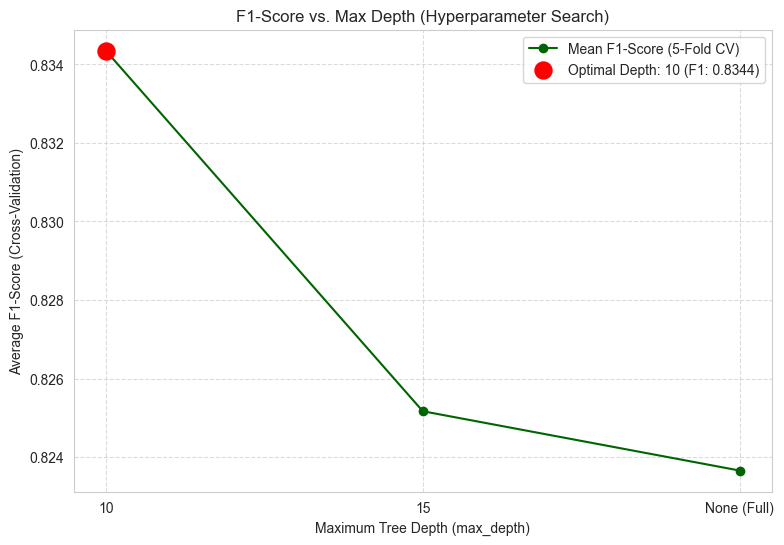

In [ ]:
# Cell 9: Graphical Hyperparameter Search Results (F1-Score vs. Max Depth)


# 1. Extrair os resultados detalhados do Grid Search
# 'grid_rf' contém os resultados do Grid Search
results = pd.DataFrame(grid_rf.cv_results_)

# 2. Encontrar os melhores parâmetros do modelo vencedor (CORRIGIDO PARA 'model__')
best_n_estimators = grid_rf.best_params_['model__n_estimators']
best_depth = grid_rf.best_params_['model__max_depth']
best_score = grid_rf.best_score_

# 3. Filtrar os resultados para isolar o efeito da profundidade (max_depth)
# NOTA: O nome do parâmetro na coluna de resultados ('param_model__max_depth') 
# também deve ser ajustado para corresponder ao nome do passo na Pipeline.
depth_results = results[
    results['param_model__n_estimators'] == best_n_estimators
].sort_values(by='param_model__max_depth')

# 4. Iniciar a Plotagem
plt.figure(figsize=(9, 6))

# Prepara os labels para o eixo X, tratando o valor 'None'
# Usamos a coluna de parâmetros do max_depth filtrada:
x_labels = depth_results['param_model__max_depth'].apply(
    lambda x: 'None (Full)' if pd.isna(x) else int(x)
)

# Plota a média de F1-Score obtida durante a Cross-Validation
plt.plot(
    x_labels.astype(str), 
    depth_results['mean_test_score'], 
    marker='o', 
    linestyle='-', 
    color='darkgreen',
    label='Mean F1-Score (5-Fold CV)'
)

# Adiciona um ponto destacado para o melhor resultado
best_depth_label = str(int(best_depth)) if not pd.isna(best_depth) else 'None (Full)'
plt.scatter(
    best_depth_label, 
    best_score, 
    color='red', 
    s=150, 
    label=f'Optimal Depth: {best_depth_label} (F1: {best_score:.4f})',
    zorder=5 
)

# 5. Configuração e Títulos (em inglês)
plt.title(f'F1-Score vs. Max Depth (Hyperparameter Search)')
plt.xlabel('Maximum Tree Depth (max_depth)')
plt.ylabel('Average F1-Score (Cross-Validation)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Salvamos a figura para que ela possa ser exibida.
plt.show()

Confusion Matrix: Optimized Random Forest


C:\Users\Leandro\AppData\Local\Temp\ipykernel_10976\2672614523.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_true_converted = y_test.replace({'No': 0, 'Yes': 1}).astype(int)


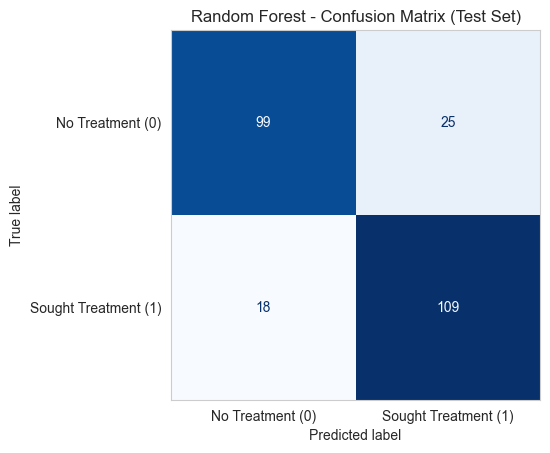

In [ ]:
# Cell 10: Confusion Matrix (Final Evaluation)

# 1. Obter o melhor estimador (o modelo otimizado da Célula 6)
# Assume-se que 'grid_rf' foi executado e que o 'best_estimator_' está disponível
best_rf = grid_rf.best_estimator_ 

# 2. Fazer previsões no conjunto de teste
y_predicted = best_rf.predict(X_test)

# 3. PASSO CRUCIAL: Converter os labels verdadeiros (y_test) de strings para inteiros binários (0/1).
# Isto evita o 'ValueError' ao garantir que os labels verdadeiros e os previstos são compatíveis.
y_true_converted = y_test.replace({'No': 0, 'Yes': 1}).astype(int)

# 4. Gerar a Matriz de Confusão
# Usamos os labels verdadeiros convertidos e os labels previstos.
cm = confusion_matrix(y_true_converted, y_predicted)

# --- Plotagem da Matriz ---

# 5. Definir os labels para a visualização no gráfico
labels_en = ['No Treatment (0)', 'Sought Treatment (1)']
# 6. Desenhar a Visualização da Matriz
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=labels_en)

print("Matriz de Confusão: Random Forest Otimizado")
disp.plot(cmap=plt.cm.Blues, colorbar=False) 
disp.ax_.grid(False) # Assegurar um aspeto de plotagem limpo
plt.title('Random Forest - Confusion Matrix (Test Set)')

# Guardar a figura para que possa ser exibida na saída.
plt.show()


C:\Users\Leandro\AppData\Local\Temp\ipykernel_10976\2745686757.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test_converted = y_test.replace({'No': 0, 'Yes': 1}).astype(int)


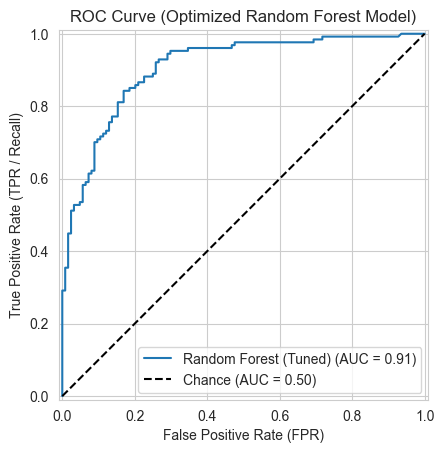

Area Under the Curve (AUC Score): 0.9071


In [ ]:
# Cell 11: ROC Curve (Receiver Operating Characteristic) - Random Forest
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import RocCurveDisplay, roc_auc_score

# --- Preparações ---
# Assumimos que 'grid_rf' foi executado na Célula 6 e que X_test está definido.
best_rf = grid_rf.best_estimator_ 

# CONVERSÃO CRÍTICA: Converte y_test de strings ('Yes'/'No') para binário (0/1).
# Isso é essencial para que o RocCurveDisplay e o roc_auc_score funcionem corretamente.
y_test_converted = y_test.replace({'No': 0, 'Yes': 1}).astype(int)

# 1. Cria a "tela" (o eixo)
fig, ax = plt.subplots()

# 2. Plota a Curva ROC do Random Forest
# Usa a versão convertida do y_test
RocCurveDisplay.from_estimator(
    best_rf, # O seu modelo RF otimizado
    X_test,
    y_test_converted, 
    name='Random Forest (Tuned)', # Nome para a legenda
    ax=ax # Usa a tela que criamos
)

# 3. Plota a linha do "acaso" (Dummy)
ax.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)') # 'k--' é uma linha preta tracejada
    
# 4. Configurações e Legenda
ax.set_title('ROC Curve (Optimized Random Forest Model)')
ax.legend(loc='lower right')
ax.set_xlabel('False Positive Rate (FPR)')
ax.set_ylabel('True Positive Rate (TPR / Recall)')

# Salvamos a figura para que ela possa ser exibida.
plt.show()

# 5. Calcula e imprime o AUC score separadamente
# Pede as probabilidades para a classe positiva (1)
y_probs_rf = best_rf.predict_proba(X_test)[:, 1] 
auc_score_rf = roc_auc_score(y_test_converted, y_probs_rf)
print(f"Area Under the Curve (AUC Score): {auc_score_rf:.4f}")